## Basic LSTM Network for News Category Prediction

In [1]:
import json
import numpy as np
import pandas as pd


# using pandas only to load the data, there seems to be issue with normal csv reader
train_data = pd.read_csv('datasets/train.csv')
test_data = pd.read_csv('datasets/test.csv')

# convert the data to numpy array
train_data = train_data.values
test_data = test_data.values
# first column is the label, second column is the title, third column is the description
print(train_data.shape)
print(test_data.shape)

(120000, 3)
(7600, 3)


In [2]:
# view all the categories
categories = set(train_data[:, 0])
print(categories)

{1, 2, 3, 4}


In [3]:
# random seed
import random
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

random.seed(232)
np.random.shuffle(train_data)
np.random.shuffle(test_data)

def remove_special_char_and_lower_case(data):
    for record in data:
        headline = record[1]
        cleaned_headline = re.sub(r'[^a-z\s]+', '', headline.lower())
        record[1] = cleaned_headline
    return data

def stemming_and_remove_stop_words(data):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    for record in data:
        headline = record[1]
        new_headline = [stemmer.stem(word) for word in headline.split() if word not in stop_words]
        record[1] = " ".join(new_headline)
    return data

train_data = remove_special_char_and_lower_case(train_data)
test_data = remove_special_char_and_lower_case(test_data)
train_data = stemming_and_remove_stop_words(train_data)
test_data = stemming_and_remove_stop_words(test_data)


In [4]:
def unique_words(train_data, test_data):
# total unique words in the dataset
    unique_words = set()
    for record in train_data:
        headline = record[1]
        for word in headline.split():
            unique_words.add(word)
    for record in test_data:
        headline = record[1]
        for word in headline.split():
            unique_words.add(word)
    return unique_words

unique_words = unique_words(train_data, test_data)
print(len(unique_words))


# we need to pad the data to make sure all the headlines are of same length
print(' ' in unique_words)

27196
False


In [5]:
# for each record separate the words, first column is the headline, second column is the label
train_data = [[record[1].split(), record[0]] for record in train_data]
test_data = [[record[1].split(), record[0]] for record in test_data]

# find the maximum length of the headline
max_len = 0
for record in train_data:
    max_len = max(max_len, len(record[0]))
for record in test_data:
    max_len = max(max_len, len(record[0]))
print("Max Length:", max_len)

# pad the data, all headlines should be of same length, add ''
for record in train_data:
    record[0] += [''] * (max_len - len(record[0]))
for record in test_data:
    record[0] += [''] * (max_len - len(record[0]))

# add padding to the unique words
unique_words.add('')
unique_words = list(unique_words)


Max Length: 14


In [6]:
# index the words and categories. Embedding layer requires the input to be in the form of integers

vocab_size = len(unique_words)
categories = len(set(record[1] for record in train_data))
print("Number of embeddings:", vocab_size)
print("Categories:", categories)

category_to_index = {category: i for i, category in enumerate(set(record[1] for record in train_data))}
print(category_to_index)
word_to_index = {word: i for i, word in enumerate(unique_words)}
index_to_word = {i: word for i, word in enumerate(unique_words)}

train_data = [[record[0], category_to_index[record[1]]] for record in train_data]
test_data = [[record[0], category_to_index[record[1]]] for record in test_data]

MAX_LENGTH = max(len(record[0]) for record in train_data)
print("Max Length:", MAX_LENGTH)
for record in train_data:
    record[0] = [word_to_index[word] for word in record[0]]
for record in test_data:
    record[0] = [word_to_index[word] for word in record[0]]

# view the data
print(train_data[0])


Number of embeddings: 27197
Categories: 4
{1: 0, 2: 1, 3: 2, 4: 3}
Max Length: 14
[[14390, 27087, 19682, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 3]


### LSTM Network


![image](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

Image Source: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [8]:
# Network Initialization

import torch

EMBEDDING_DIM = 10
embeddings = torch.randn(vocab_size, EMBEDDING_DIM)/np.sqrt(vocab_size)
HIDDEN_LAYER_DIM = 64

# forget gate
Wf = torch.randn(EMBEDDING_DIM+HIDDEN_LAYER_DIM, HIDDEN_LAYER_DIM)/np.sqrt(EMBEDDING_DIM+HIDDEN_LAYER_DIM)
bf = torch.randn(HIDDEN_LAYER_DIM)/np.sqrt(HIDDEN_LAYER_DIM)
# input gate
Wi = torch.randn(EMBEDDING_DIM+HIDDEN_LAYER_DIM, HIDDEN_LAYER_DIM)/np.sqrt(EMBEDDING_DIM+HIDDEN_LAYER_DIM)
bi = torch.randn(HIDDEN_LAYER_DIM)/np.sqrt(HIDDEN_LAYER_DIM)
# output gate
Wo = torch.randn(EMBEDDING_DIM+HIDDEN_LAYER_DIM, HIDDEN_LAYER_DIM)/np.sqrt(EMBEDDING_DIM+HIDDEN_LAYER_DIM)
bo = torch.randn(HIDDEN_LAYER_DIM)/np.sqrt(HIDDEN_LAYER_DIM)
# candidate
Wc = torch.randn(EMBEDDING_DIM+HIDDEN_LAYER_DIM, HIDDEN_LAYER_DIM)/np.sqrt(EMBEDDING_DIM+HIDDEN_LAYER_DIM)
bc = torch.randn(HIDDEN_LAYER_DIM)/np.sqrt(HIDDEN_LAYER_DIM)

# feed forward network
W1 = torch.randn(HIDDEN_LAYER_DIM, HIDDEN_LAYER_DIM)/np.sqrt(HIDDEN_LAYER_DIM)
b1 = torch.randn(HIDDEN_LAYER_DIM)/np.sqrt(HIDDEN_LAYER_DIM)
W2 = torch.randn(HIDDEN_LAYER_DIM, categories)/np.sqrt(HIDDEN_LAYER_DIM)
b2 = torch.randn(categories)/np.sqrt(HIDDEN_LAYER_DIM)

parameters = [embeddings, Wf, bf, Wi, bi, Wo, bo, Wc, bc, W1, b1, W2, b2]
for parameter in parameters:
    parameter.requires_grad = True

Forget Gate: ft = σ(Wf * [ht-1, xt] + bf) 

Input Gate: it = σ(Wi * [ht-1, xt] + bi)

Output Gate: ot = σ(Wo * [ht-1, xt] + bo)

Candidate: ~Ct = tanh(Wc * [ht-1, xt] + bc)

Cell State: Ct = ft * Ct-1 + it * ~Ct

Hidden State: ht = ot * tanh(Ct)


In [24]:
BATCH_SIZE = 32
LEARNING_RATE = 0.01
EPOCHS = 10000

for _ in range(EPOCHS):

    batch  = random.sample(train_data, BATCH_SIZE)
    X = [record[0] for record in batch]
    y = [record[1] for record in batch]

    h_t = torch.zeros(BATCH_SIZE, HIDDEN_LAYER_DIM)
    c_t = torch.zeros(BATCH_SIZE, HIDDEN_LAYER_DIM)

    # forward pass
    for index in range(MAX_LENGTH):
        # lstm cell
        x_i = [[record[index] for record in X]]
        emb = embeddings[x_i]
        ft = torch.sigmoid(torch.cat((emb, h_t), dim=1)@Wf + bf)
        it = torch.sigmoid(torch.cat((emb, h_t), dim=1)@Wi + bi)
        ct = torch.tanh(torch.cat((emb, h_t), dim=1)@Wc + bc)
        c_t = ft*c_t + it*ct
        ot = torch.sigmoid(torch.cat((emb, h_t), dim=1)@Wo + bo)
        h_t = ot*torch.tanh(c_t)
    # feed forward network
    h1 = torch.tanh(h_t @ W1 + b1)
    logits = h1 @ W2 + b2 
    logits_maxes = logits.max(1, keepdim=True).values  # keepdims=True, other wise squished to 1D, and not broadcasted
    logits_norm = logits - logits_maxes
    counts = logits_norm.exp()
    counts_sum_inv = counts.sum(1, keepdim=True)
    y_prob = counts * counts_sum_inv**-1
    logprobs = y_prob.log()
    loss = -logprobs[range(BATCH_SIZE), y].mean()

    # backpropagation
    for parameter in parameters:
        parameter.grad = None
    
    loss.backward()

    # update the parameters
    for parameter in parameters:
        parameter.data -= LEARNING_RATE * parameter.grad
        
    print(loss.item())



0.6594164371490479
0.3757771849632263
0.1697615683078766
0.21504227817058563
0.2941739857196808
0.39511531591415405
0.2109118551015854
0.31706058979034424
0.2345917820930481
0.4105989336967468
0.13521963357925415
0.582026481628418
0.2756947875022888
0.3233412504196167
0.5678827166557312
0.09291777014732361
0.20548675954341888
0.1346338838338852
0.18428954482078552
0.08355506509542465
0.32995715737342834
0.23846010863780975
0.20485657453536987
0.1972649246454239
0.33693334460258484
0.2725461721420288
0.22117185592651367
0.22539383172988892
0.18357837200164795
0.1921387016773224
0.3809380531311035
0.3642720580101013
0.34748709201812744
0.2179345041513443
0.12953536212444305
0.40987658500671387
0.29359865188598633
0.11329297721385956
0.2930324673652649
0.44804078340530396
0.30715325474739075
0.2706819772720337
0.3088659644126892
0.21552814543247223
0.24628838896751404
0.08160077035427094
0.3444657325744629
0.23543569445610046
0.5590977668762207
0.3160247206687927
0.203398659825325
0.19888

Accuracy:  0.8611842105263158
Number of test records:  7600
Number of correct predictions:  6545


<BarContainer object of 4 artists>

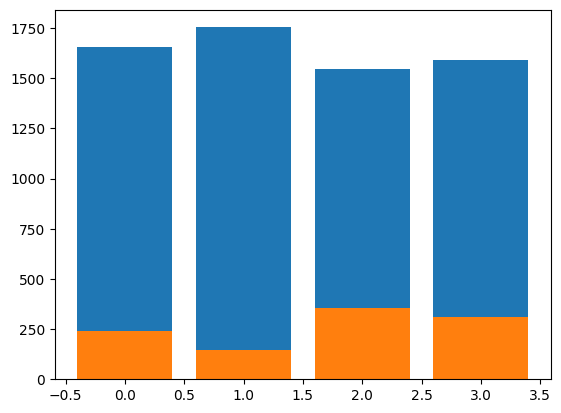

In [25]:
import matplotlib.pyplot as plt
# test the model
# record which category the model predicts correctly and which it does not
correct = 0
total = 0
categories_correct = {}
categories_incorrect = {}
for record in test_data:
    X = record[0]
    y = record[1]
    
    h_t = torch.zeros(1, HIDDEN_LAYER_DIM)
    c_t = torch.zeros(1, HIDDEN_LAYER_DIM)
    for index in range(MAX_LENGTH):
        x_i = X[index]
        emb = embeddings[x_i]
        # emb has 1x10
        emb = emb.view(1, -1)
        ft = torch.sigmoid(torch.cat((emb, h_t), dim=1)@Wf + bf)
        it = torch.sigmoid(torch.cat((emb, h_t), dim=1)@Wi + bi)
        ct = torch.tanh(torch.cat((emb, h_t), dim=1)@Wc + bc)
        c_t = ft*c_t + it*ct
        ot = torch.sigmoid(torch.cat((emb, h_t), dim=1)@Wo + bo)
        h_t = ot*torch.tanh(c_t)

    h1 = torch.tanh(h_t @ W1 + b1)
    logits = h1 @ W2 + b2
    y_pred = logits.argmax().item()
    if y_pred == y:
        correct += 1
        if y not in categories_correct:
            categories_correct[y] = 0
        categories_correct[y] += 1
    else:
        if y not in categories_incorrect:
            categories_incorrect[y] = 0
        categories_incorrect[y] += 1
        #headline = " ".join(index_to_word[i] for i in X)
        #print("Headline: ", headline)
    total += 1
print("Accuracy: ", correct/total)
print("Number of test records: ", total)
print("Number of correct predictions: ", correct)


# plot categories correct and incorrect
plt.bar(categories_correct.keys(), categories_correct.values())
plt.bar(categories_incorrect.keys(), categories_incorrect.values())
